In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

# Constants

In [85]:
# Constants
TEST_DATA_DIR = 'data/test'
TRAIN_DATA_DIR = 'raw-data/train'
METADATA_PATH = 'raw-data/train.csv'

IMG_WIDTH = 32
IMG_HEIGTH = 32
BATCH_SIZE = 32
EPOCHS = 15

# Load, augment & preprocess data

In [86]:
# Load labels
metadata = pd.read_csv(METADATA_PATH)
metadata.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [89]:
train_data = []

for index, row in metadata.iterrows():
    image = cv2.imread(f'{TRAIN_DATA_DIR}/{row.id}')
    label = 'has_cactus' if row.has_cactus else "no_cactus" 
    train_data.append({'image': image, 'label': label})

    # Augment 30% of the data
    if np.random.random() < 0.3:
        # Horizontal or vertical flip
        flag = np.random.randint(0, 1)
        image = cv2.flip(image, flag)
        train_data.append({'image': image, 'label': label})
        
# Convert to numpy array in order to shuffle the data
train_data = np.asarray(train_data)
np.random.shuffle(train_data)
print(len(train_data))

22715


In [3]:
train_data = []
labels = ['no_cactus', 'has_cactus']

# Load images and append to an array with the correpsonding label.
for i, label in enumerate(labels):
    for fname in os.listdir(f'{TRAIN_DATA_DIR}/{label}'):
        image = cv2.imread(f'{TRAIN_DATA_DIR}/{label}/{fname}', cv2.COLOR_BGR2RGB)
        train_data.append({'image': image, 'label': label})

        # Augment 30% of the data
        if np.random.random() < 0.3:
            # Horizontal or vertical flip
            flag = np.random.randint(0, 1)
            image = cv2.flip(image, flag)
            train_data.append({'image': image, 'label': label})

# Convert to numpy array in order to shuffle the data
train_data = np.asarray(train_data)
np.random.shuffle(train_data)
print(len(train_data))

22832


In [4]:
# Split into lists of images and labels
X =  [x['image'] for x in train_data]
y = [x['label'] for x in train_data]

# Encode label
encoder = LabelBinarizer()
y = encoder.fit_transform(y)
# Horizontally stack the array to get it into the correct shape
y = np.hstack((y, 1 - y))

# Split into training and test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Convert to numpy arrays for Keras
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

# Build model
Based on this article: https://towardsdatascience.com/deciding-optimal-filter-size-for-cnns-d6f7b56f9363 it is better to use small kernel sizes, like 3x3, for images where the usefull features are local. This is the case for my images where a cactus can be in different spots of the picture and often does not take up the entire image.

In [5]:
# Build base model.
base_model = Sequential()
kernel_size = (3, 3)

base_model.add(Conv2D(64, kernel_size=kernel_size, activation='relu', input_shape=(IMG_HEIGTH, IMG_WIDTH, 3)))
base_model.add(Dropout(0.3))
base_model.add(Conv2D(32, kernel_size=kernel_size, activation='relu'))
base_model.add(Dropout(0.3))
base_model.add(MaxPooling2D((2,2), strides=(2, 2)))
base_model.add(Flatten())
base_model.add(Dense(2, activation='softmax'))

In [6]:
base_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        18464     
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 1

In [7]:
base_history = base_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/15
571/571 [==============================] - 44s 78ms/step - loss: 3.0201 - accuracy: 0.7070
Epoch 2/15
571/571 [==============================] - 42s 74ms/step - loss: 0.3726 - accuracy: 0.8189
Epoch 3/15
571/571 [==============================] - 42s 74ms/step - loss: 0.4042 - accuracy: 0.8472
Epoch 4/15
571/571 [==============================] - 42s 73ms/step - loss: 0.3777 - accuracy: 0.8350
Epoch 5/15
571/571 [==============================] - 42s 73ms/step - loss: 0.3364 - accuracy: 0.8488
Epoch 6/15
571/571 [==============================] - 42s 74ms/step - loss: 0.3623 - accuracy: 0.8452
Epoch 7/15
571/571 [==============================] - 42s 74ms/step - loss: 0.3402 - accuracy: 0.8498
Epoch 8/15
571/571 [==============================] - 42s 74ms/step - loss: 0.3613 - accuracy: 0.8483
Epoch 9/15
571/571 [==============================] - 42s 73ms/step - loss: 0.3671 - accuracy: 0.8423
Epoch 10/15
571/571 [==============================] - 42s 73ms/step - loss: 0.396

# Evaluate model

Text(0.5, 0, 'Epoch')

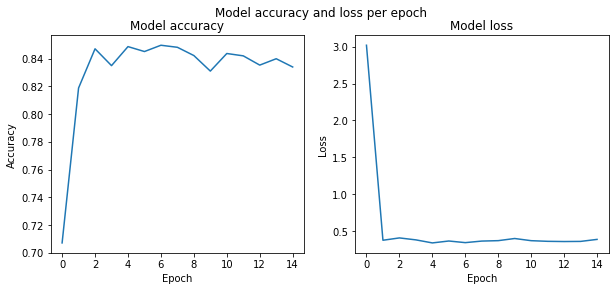

In [65]:
# Visualize accuracy
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('Model accuracy and loss per epoch')

axes[0].plot(base_history.history['accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')

axes[1].plot(base_history.history['loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')

In [35]:
# Evaluate on test set
scores = base_model.predict(X_test)
predictions = np.argmax(scores, axis=1)

true = np.argmax(y_test, axis=1)

# inverse the encoding of the labels
predictions = encoder.inverse_transform(predictions)
true = encoder.inverse_transform(true)

In [67]:
df = pd.DataFrame(
    data=confusion_matrix(true, predictions, labels=labels),
    columns=labels,
    index=labels
)

df.head()

,no_cactus,has_cactus
no_cactus,2502,933
has_cactus,5,1127


In [79]:
# Calculate True Negative (tn), False Positive (fp), False Negative (fn) and True Positive (tp) 
tn, fp, fn, tp = confusion_matrix(true, predictions).ravel()

table = pd.DataFrame({'type': ['True Negative', 'True Positive', 'False Negative', 'False Positive'], 'value': [tn, fp, fn, tp]})

table.head()

,type,value
0,True Negative,1127
1,True Positive,5
2,False Negative,933
3,False Positive,2502


In [80]:
recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1 = ((2 * recall) * precision) / (recall + precision)

print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')

Recall: 0.7283842794759825
Precision: 0.9980055843637814
F1 Score: 0.8421406933692359


In [81]:
# Show images where the prediction was wrong
fn_images = []
fp_images = []

for index, (predicted_label, true_label) in enumerate(zip(predictions, true)):
    if str(predicted_label) == 'no_cactus' and str(true_label) == 'has_cactus':
        fn_images.append(X_test[index])

# Get Indices of False Positives
for index, (predicted_label, true_label) in enumerate(zip(predictions, true)):
    if str(predicted_label) == 'has_cactus' and str(true_label) == 'no_cactus':
        fp_images.append(X_test[index])


933


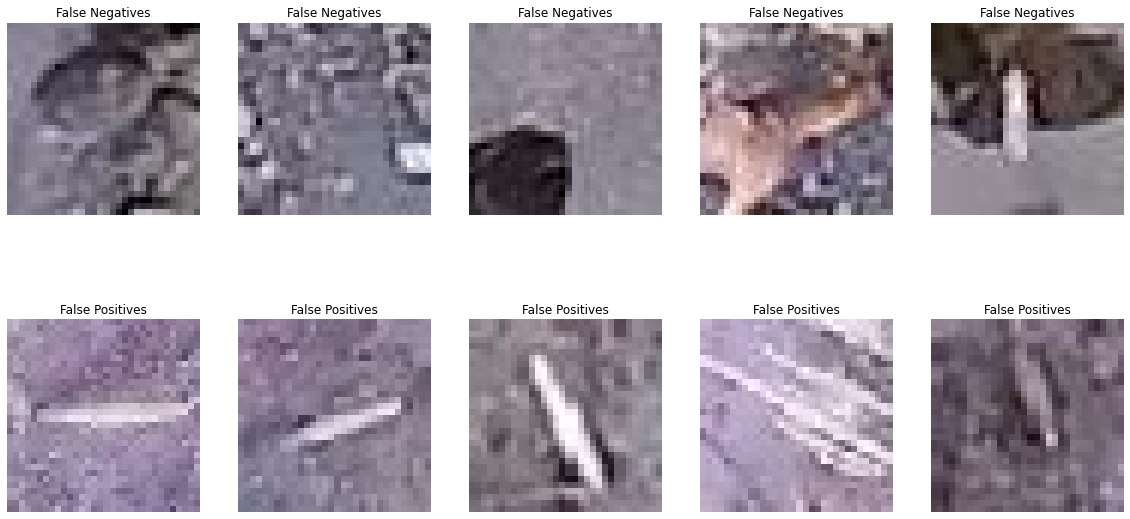

In [84]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for index, img in enumerate(fn_images[:5]):
    axes[0, index].imshow(img)
    axes[0, index].axis('off')
    axes[0, index].set_title('False Negatives')

for index, img in enumerate(fp_images[:5]):
    axes[1, index].imshow(img)
    axes[1, index].axis('off')
    axes[1, index].set_title('False Positives')

# Export model

In [ ]:
base_model.save('models/base_cnn')